<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/late_fusion_Eff_net_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

## Read, Split train_val & oversample train set


In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']

df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
72,IDRiD_073,2
256,IDRiD_257,0
290,IDRiD_291,1
311,IDRiD_312,0
389,IDRiD_390,4


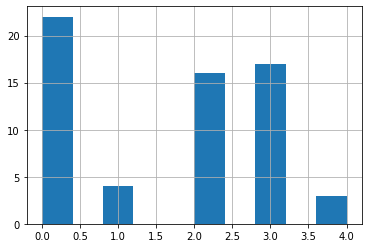

In [4]:
val_df['Retinopathy grade'].hist()

In [5]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 351


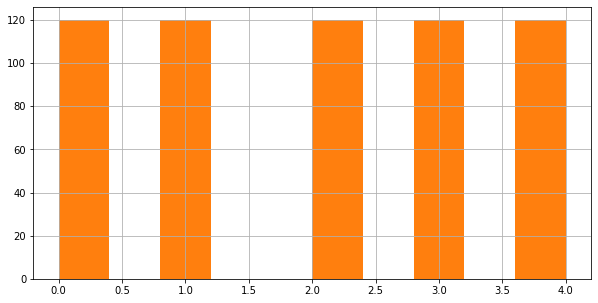

In [6]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [7]:
image_names = train_df['Image name'];
im_size = 512;

train_labels = [];
for label in train_df['Retinopathy grade']:
    #for i in range(2): # 2 times for data augmentation
    train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((len(train_labels),im_size,im_size,3))

index=0
for image_name in image_names:
    #read image
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index,:,:,0:3] = img

    #rot 180
    #train_images[index + 1] = np.rot90(np.rot90(img))
    
    index = index + 1

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  600
(600, 512, 512, 3)
(600, 5)


array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

## Read test_df


In [9]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


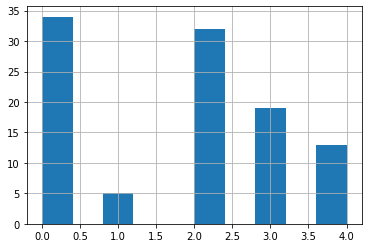

In [10]:
test_df['Retinopathy grade'].hist()

In [11]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [12]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of val set ",len(val_image_names))
im_size = 512;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);
print("max value of image ",np.max(val_images))
val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of val set  62
max value of image  255
(62, 512, 512, 3)
(62, 5)


In [13]:
val_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
val_datagen.fit(val_images)

In [14]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (600, 512, 512, 3)
train y size  (600, 5)
test x size  (103, 512, 512, 3)
test y size  (103, 5)
val x size  (62, 512, 512, 3)
val y size  (62, 5)


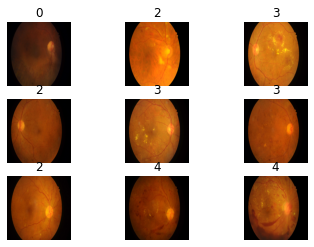

In [15]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(train_images[2*i+1])
  plt.title("{}".format(np.argmax(train_labels[2*i+1]))) 
  plt.axis('off')

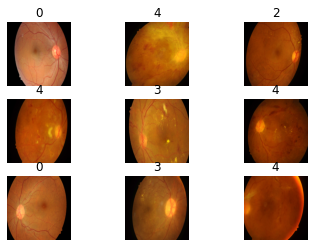

In [16]:
x=train_datagen.flow(train_images, train_labels,batch_size=9,shuffle=True)
for i,(img,lbl) in enumerate(x):
  for j in range(9):
    ax=plt.subplot(3,3,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break
del x

In [17]:
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [18]:
from tensorflow.keras.models import model_from_json

def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

model_MA  Model loaded and compiled


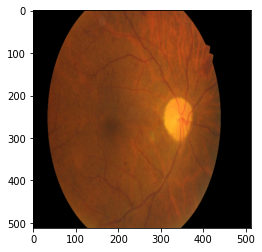

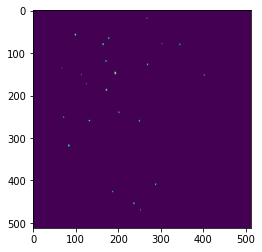

NameError: ignored

In [19]:
se_model=load_seg_model("model_MA")
for i in range(1):
  lesion=se_model(val_images[i:1+i,:,:,:])
  plt.imshow(val_images[i,:,:,:])
  plt.show()
  plt.imshow(np.squeeze(np.squeeze(lesion,axis=0),axis=2))
  plt.show()
  lesion=se_model(val_images_1[i:1+i,:,:,:])
  plt.imshow(val_images_1[i,:,:,:])
  plt.show()
  plt.imshow(np.squeeze(np.squeeze(lesion,axis=0),axis=2))
  plt.show()

In [ ]:
#to check if the augmentationi affecteing the lesions
se_model=load_seg_model("model_MA")
x=train_datagen.flow(train_images, train_labels,batch_size=1,shuffle=True)
for i,(img_,lbl) in enumerate(x):
  lesion=se_model(img_)
  plt.imshow((np.squeeze(img_,axis=0))
  plt.show()
  plt.imshow(np.squeeze(np.squeeze(lesion,axis=0),axis=2))
  plt.show()

In [20]:
def build_model(num_classes,model_name):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    
    IMG_SIZE=224
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_densenet')(input_0)
    #input_0_ma  =tf.keras.layers.experimental.preprocessing.Resizing(640,640,  name='resize_ma')(input_0)
    #input_1 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    #input_ex=layers.Input(shape=(512,512,1))
    #input_se=layers.Input(shape=(512,512,1))
    #input_ma=layers.Input(shape=(640,640,1))
    if model_name=='DenseNet121':
      base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    elif model_name=='EfficientNetB0':
      base_model = EfficientNetB0(include_top=False, input_tensor=input_1*255, weights="imagenet")
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE_1")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    ma_model._name='model_ma'
    se_model._name='model_se'
    he_model._name='model_he'
    for layer in he_model.layers:
      layer._name = layer.name + '_he'
    for layer in se_model.layers:
      layer._name = layer.name + '_se'
    for layer in ex_model.layers:
      layer._name = layer.name + '_ex'
    for layer in ma_model.layers:
      layer._name = layer.name + '_ma'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)
    #les_ma=tf.keras.layers.experimental.preprocessing.Resizing(640,640,  name='resize_ma')(les_ma)
    f_lesions=layers.Concatenate()([les_ex,les_se,les_ma,les_he])
    #block1
    f_lesions=Conv2D(8,3,strides=(2,2),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='1_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block2
    f_lesions=Conv2D(16,3,strides=(2,2),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='2_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block3
    f_lesions=Conv2D(32,3,strides=(2,2),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='3_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block4
    #f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    #f_lesions=layers.BatchNormalization(name='4_bn')(f_lesions)
    #f_lesions=layers.Activation('relu')(f_lesions)
    #f_lesions=MaxPooling2D()(f_lesions)
    #block5 
    #f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    #f_lesions=layers.BatchNormalization(name='5_bn')(f_lesions)
    #f_lesions=layers.Activation('relu',)(f_lesions)
    #f_lesions=MaxPooling2D()(f_lesions)
    #block6
    #f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    #f_lesions=layers.BatchNormalization(name='6_bn')(f_lesions)
    #f_lesions=layers.Activation('relu')(f_lesions)
    #f_lesions=MaxPooling2D()(f_lesions)
    
    f_lesions=layers.GlobalMaxPooling2D()(f_lesions)
    #print(f_lesions.shape)
    x=layers.GlobalAveragePooling2D()(base_model.output)
    x=layers.Concatenate()([x,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten")(x)
    
    top_dropout_rate = 0.2
    #x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input_0, outputs, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [21]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model=build_model(5,'EfficientNetB0')

model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


In [22]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 6,267,806
Trainable params: 409,421
Non-trainable params: 5,858,385


In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [23]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 8)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=10,shuffle=True),steps_per_epoch=len(train_images) / 10,
               epochs = 50, callbacks = [early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=10));

Epoch 1/50
60/60 [==============================] - 79s 998ms/step - loss: 1.5646 - accuracy: 0.2869 - val_loss: 1.6089 - val_accuracy: 0.3387
Epoch 2/50
60/60 [==============================] - 53s 870ms/step - loss: 1.2729 - accuracy: 0.3872 - val_loss: 1.7831 - val_accuracy: 0.2903
Epoch 3/50
60/60 [==============================] - 52s 866ms/step - loss: 1.1470 - accuracy: 0.4831 - val_loss: 1.7003 - val_accuracy: 0.3387
Epoch 4/50
60/60 [==============================] - 52s 867ms/step - loss: 1.1039 - accuracy: 0.5038 - val_loss: 1.7904 - val_accuracy: 0.3226
Epoch 5/50
60/60 [==============================] - 53s 872ms/step - loss: 1.0657 - accuracy: 0.5250 - val_loss: 1.7762 - val_accuracy: 0.2581
Epoch 6/50
60/60 [==============================] - 52s 867ms/step - loss: 1.0032 - accuracy: 0.5475 - val_loss: 1.7580 - val_accuracy: 0.3548
Epoch 7/50
60/60 [==============================] - 52s 867ms/step - loss: 0.9395 - accuracy: 0.5869 - val_loss: 1.4840 - val_accuracy: 0.5161

[[17  0  5  0  0]
 [ 3  0  0  0  1]
 [ 6  1  9  0  0]
 [ 5  0  5  5  2]
 [ 1  0  1  0  1]]
0.5161290322580645  accuracy


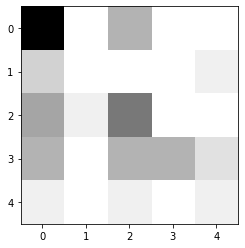

In [31]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=np.zeros((val_labels.shape))
for i in range(7):
  pred_y_[6*i:6*i+6]=model.predict(val_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")

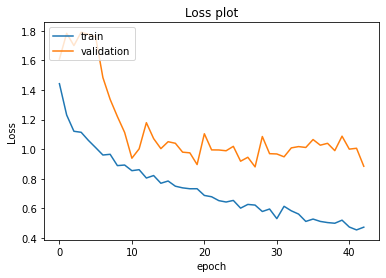

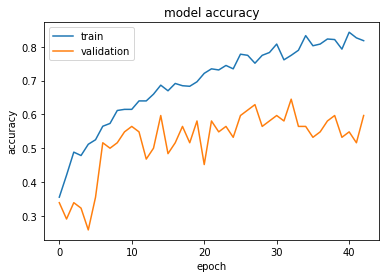

In [32]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

[[18  5 10  0  1]
 [ 1  2  2  0  0]
 [ 4  5 18  5  0]
 [ 1  0  9  7  2]
 [ 0  0  4  1  8]]
0.5145631067961165  acuracy


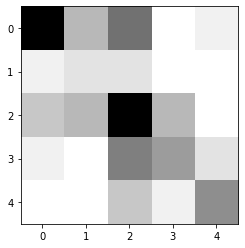

In [33]:
#preds = model.evaluate(test_images, test_labels)
#print("Loss = " + str(preds[0]))
#print("Test accuracy = " + str(preds[1]))
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

## acc with TTA

In [45]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((100,5))
x=test_datagen.flow(test_images,test_labels,batch_size=10)
test_y_=np.zeros((100,5))

[[18 12  4  0  0]
 [ 1  3  1  0  0]
 [ 2  6 17  4  1]
 [ 1  0  7  7  3]
 [ 0  0  2  3  8]]
0.53  acuracy


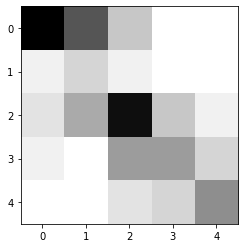

In [46]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[10*i:10*i+10]=model.predict(img)
  test_y_[10*i:10*i+10,:]=lbl
  if i==9:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," acuracy")

In [48]:
del test_datagen

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/model_eff_late_fusion.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/model_eff_late_fusion.h5")
print("Saved model to disk")

## unfreeze and train

In [47]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:]=='bn':
    layer.trainable=False
    count+=1
print(count," layers of bn freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

52  layers of bn freezed
Total params: 6,267,806
Trainable params: 6,175,913
Non-trainable params: 91,893


In [53]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate = 1e-7, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=2,shuffle=True),steps_per_epoch=len(train_images) / 2,
               epochs = 20,callbacks=[early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=4));

Epoch 1/20
300/300 [==============================] - 239s 708ms/step - loss: 0.4019 - accuracy: 0.8652 - val_loss: 0.9315 - val_accuracy: 0.6290
Epoch 2/20
300/300 [==============================] - 208s 692ms/step - loss: 0.4460 - accuracy: 0.8412 - val_loss: 0.8857 - val_accuracy: 0.5968
Epoch 3/20
300/300 [==============================] - 207s 691ms/step - loss: 0.4328 - accuracy: 0.8520 - val_loss: 0.8736 - val_accuracy: 0.5484
Epoch 4/20
300/300 [==============================] - 207s 691ms/step - loss: 0.4971 - accuracy: 0.8340 - val_loss: 0.9350 - val_accuracy: 0.5806
Epoch 5/20
300/300 [==============================] - 207s 691ms/step - loss: 0.5086 - accuracy: 0.7976 - val_loss: 1.0155 - val_accuracy: 0.6129
Epoch 6/20
300/300 [==============================] - 207s 691ms/step - loss: 0.4237 - accuracy: 0.8796 - val_loss: 1.0713 - val_accuracy: 0.5645
Epoch 7/20
300/300 [==============================] - 207s 691ms/step - loss: 0.4455 - accuracy: 0.8429 - val_loss: 0.9173 -

[[20  5  8  0  1]
 [ 1  2  2  0  0]
 [ 5  3 18  4  2]
 [ 1  0  8  6  4]
 [ 0  0  4  1  8]]


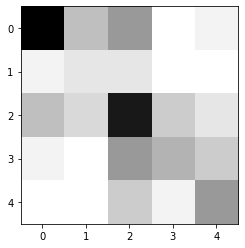

In [103]:
pred_y_=np.zeros((test_labels.shape))
for i in range(11):
  pred_y_[10*i:10*i+10]=model.predict(test_images[10*i:10*i+10])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')

In [104]:
from sklearn.metrics import precision_score,accuracy_score
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

0.5242718446601942  acuracy


In [57]:
del train_images,train_labels
del train_datagen

In [100]:
del x,test_datagen,test_y_,pred_y_tta

In [101]:
test_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
test_datagen.fit(test_images)
pred_y_tta=np.zeros((100,5))
x=test_datagen.flow(test_images,test_labels,batch_size=10)
test_y_=np.zeros((100,5))

[[18  7  6  0  1]
 [ 1  3  1  0  0]
 [ 2  6 19  5  0]
 [ 1  0  6  8  4]
 [ 0  0  5  1  6]]
0.54  accuracy


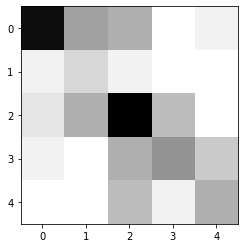

In [102]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[10*i:10*i+10]=model.predict(img)
  test_y_[10*i:10*i+10,:]=lbl
  if i==9:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")